## Jupyter to produce maps in Hydrogen Perspective
Kathleen Kennedy, 2023

In [2]:
import pandas as pd
import numpy as np
import os
import geopandas
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import seaborn as sns
import country_converter as coco
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
%matplotlib notebook

### IEA Projects Database
<br>Data available at https://www.iea.org/data-and-statistics/data-product/hydrogen-production-and-infrastructure-projects-database
<br>Last updated October 2023

In [3]:
# Read in IEA data 
iea_df = pd.read_csv('iea_capacity_2023.csv')
iea_df = iea_df.dropna(subset = ['Country']).reset_index(drop=True)

# List of member nations in EU: Austria, Belgium, Bulgaria, Croatia, Cyprus, Czech Republic,
# Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Ireland, Italy, Latvia, 
# Lithuania, Luxembourg, Malta, Netherlands, Poland, Portugal, Romania, Slovakia, Slovenia,
# Spain, Sweden
eu = ['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FIN','FRA','DEU','GRC','HUN','IRL',
     'ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU','SVK','SVN','ESP','SWE']

# Classify EU countries manually
iea_df['Region'] = iea_df['Country'].apply(lambda x: 'EUN' if x in eu else x)
iea_df['Region'] = iea_df['Region'].apply(lambda x: 'EUN' if len(x) > 3 else x)
iea_df['Capacity_MWel'] = iea_df['Capacity_MWel'].apply(pd.to_numeric)

# Sum capacity by country and convert to GWel
iea_reg = (iea_df.groupby(by=['Country']).sum(numeric_only = True)
               .sort_values(by='Capacity_MWel', ascending = False)
          .reset_index())
iea_reg['Capacity_GWel'] = iea_reg['Capacity_MWel']/1000
iea_reg['Capacity_GWel'] = iea_reg['Capacity_GWel'].apply(pd.to_numeric)

# Convert country codes to names for matching
iea_reg['Country_name'] = iea_reg['Country'].apply(lambda x: coco.convert(x, to='name_short'))

# Save data to file for manual review
iea_reg.to_csv('iea_capacity_data.csv', index=False, encoding='utf-8')

In [3]:
# Set up a geolocator
geolocator = Nominatim(user_agent="kmkenne5@umd.edu")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Read in IEA data
ports = pd.read_csv('iea_h2_ports_2023.csv')
ports = ports[['Country','Location','Trade']]
ports['combined'] = ports['Location'] + ', ' + ports['Country']

# Search for coordinates of named locations
ports['loc'] = ports['Location'].apply(geocode)
ports['point'] = ports['loc'].apply(lambda x: tuple(x.point) if x else None)

In [4]:
# Drop datapoints where location is unknown
ports = ports.dropna(subset=['point'])

# Convert location data into a GeoDataFrame
ports['Latitude'] = ports['point'].apply(lambda x: x[0])
ports['Longitude'] = ports['point'].apply(lambda x: x[1])
gdf = geopandas.GeoDataFrame(ports, 
                             geometry=geopandas.points_from_xy(ports.Longitude, ports.Latitude), 
                             crs="EPSG:4326")

<IPython.core.display.Javascript object>


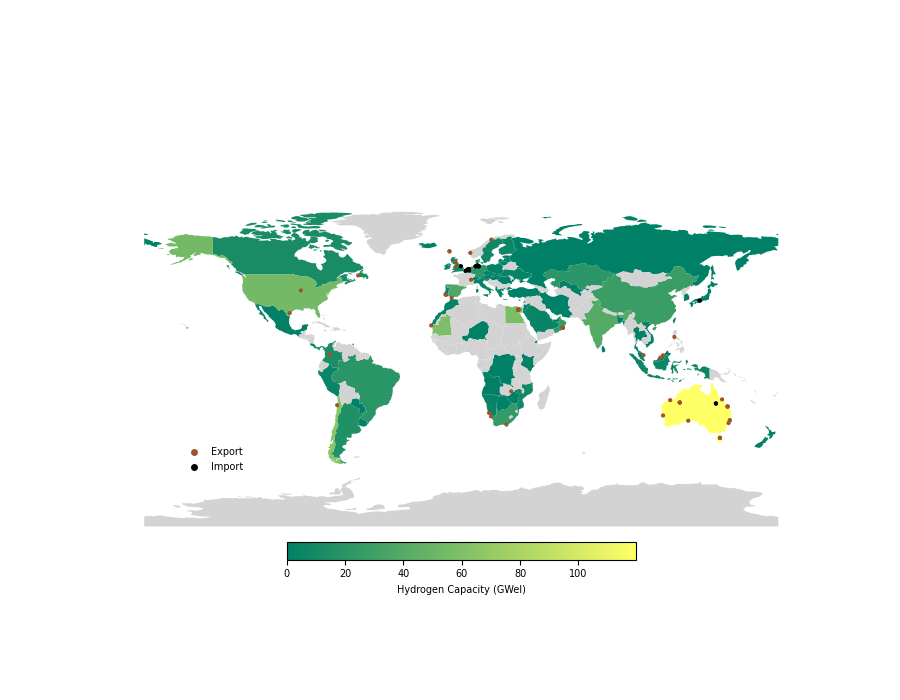

In [47]:
# Set up world map dataframe
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[['name','iso_a3','geometry','pop_est']]
country_shapes = world.merge(iea_reg, right_on='Country',left_on='iso_a3',how='left')

# Make map figure
fig, gax = plt.subplots(figsize=(9, 7))

plt.rc('font', family='sans-serif') 
plt.rcParams['font.size'] = 7

# Make chloropleth map with capacity data
country_shapes.plot(ax=gax, column='Capacity_GWel',
                    cmap='summer', legend=True,
                    missing_kwds={'color': 'lightgrey'},
                    legend_kwds={'shrink': 0.5,'orientation': 'horizontal',
                                 'label': 'Hydrogen Capacity (GWel)',
                                 'pad': 0})

# Make scatterplot map of import/export facilities
palette = {'Import':'black','Export':'sienna'}
cmap = mplcolors.ListedColormap([palette[b] for b in gdf.Trade.unique()])
      
gdf.plot(ax = gax, column = 'Trade', 
         markersize = 4, legend = True,
         cmap = cmap,
         legend_kwds={'bbox_to_anchor':(0.2, 0.3),
                      'fontsize':7,
                      'frameon':False,
                      'markerscale':0.5})

gax.set_axis_off()

# Save map
plt.savefig('Figs/H2_iea_data.png', bbox_inches='tight')

In [3]:
# Read in roadmap data
roads = pd.read_csv('h2_export_summary.csv')

# Set up world map dataframe
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[['name','iso_a3','geometry','pop_est']]
roadmp_shapes = world.merge(roads, right_on='Country',left_on='name',how='left')

# Set export_focus to preliminary when roadmap is not yet available
def upd_exp(row):
    if pd.isna(row.Export_focus):
        return row.Roadmap
    else: return row.Export_focus
    
values = {"Roadmap": 'No Roadmap'}
roadmp_shapes.fillna(value=values, inplace = True)
roadmp_shapes['Export_focus'] = roadmp_shapes.apply(lambda row: upd_exp(row), axis = 1)

#roadmp_shapes.to_csv('roadmap_data.csv', index=False, encoding='utf-8')

<IPython.core.display.Javascript object>


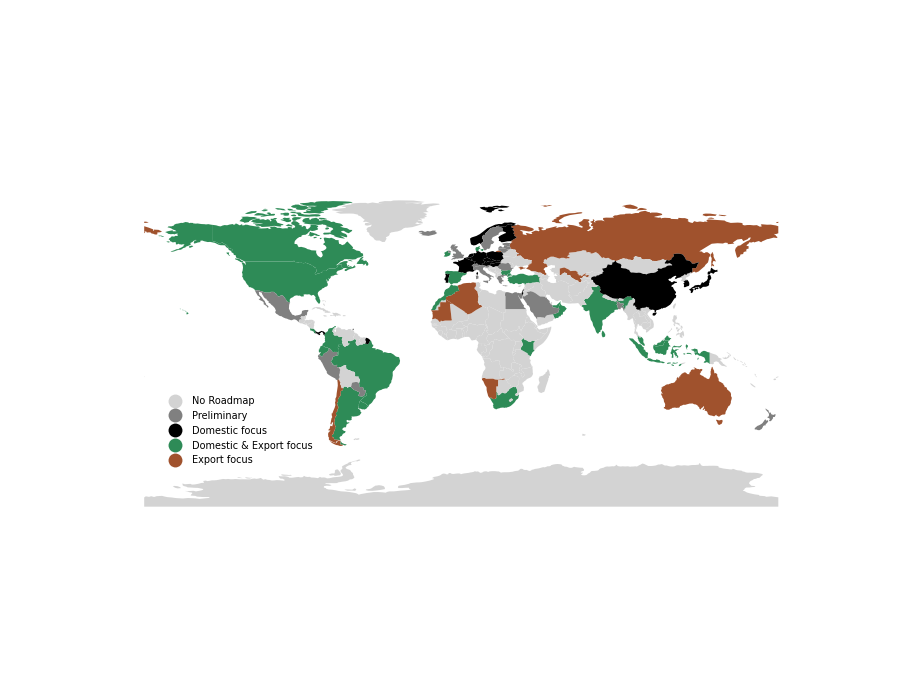

In [49]:
# Make dictionary for ordering legend and invert dictionary
legdict={'No Roadmap': 'a', 'Preliminary': 'b', 'Domestic focus': 'c', 
         'Domestic & Export focus': 'd', 'Export focus': 'e'}
inv_dict = {v: k for k, v in legdict.items()}

# Create new column for ordered legend
roadmp_shapes['ordered'] = roadmp_shapes['Export_focus'].apply(lambda x: legdict[x])

# Create custom colormap for legend categories
palette = {'a': 'lightgrey', 'b': 'sienna', 'c': 'seagreen', 'd': 'grey', 'e': 'black'}
cmap = mplcolors.ListedColormap([palette[b] for b in roadmp_shapes.ordered.unique()])

# Make map figure
fig, gax = plt.subplots(figsize=(9, 7))

plt.rc('font', family='sans-serif') 
plt.rcParams['font.size'] = 7

# Make chloropleth map showing roadmap status
roadmp_shapes.plot(ax=gax, column='ordered',
                   legend=True, categorical = True,
                   cmap = cmap,
                   legend_kwds={'bbox_to_anchor':(0.3, 0.4),
                                'fontsize':7,
                                'frameon':False})

gax.set_axis_off()

def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

replace_legend_items(gax.get_legend(), inv_dict)

plt.savefig('Figs/H2_roadmap_simplified.png', bbox_inches='tight')